# bike model results

In [65]:
import h5py
import pandas as pd
import pylab as P
from IPython.display import display, display_pretty, Javascript, HTML
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
# Show charts in notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## destination

In [2]:
# Load daysim outputs results
model = h5py.File(r'D:\soundcast\soundcast\outputs\daysim_outputs.h5')

In [3]:
# Load survey data
survey = h5py.File(r'D:\soundcast\soundcast\scripts\summarize\inputs\calibration\survey.h5')

In [4]:
def get_df(h5file, table, fields, nested=False):
    '''return all fields from h5 table'''
    data = {}
    for field in fields:
        if nested:
            data[field] = [i[0] for i in h5file[table][field][:]]
        else:   
            data[field] = [i for i in h5file[table][field][:]]
        
    return pd.DataFrame(data)

In [5]:
# List of columns we want to import
trip_fields = ['dorp','dtaz','otaz','opurp','mode','dpcl','opcl','arrtm','deptm']

In [41]:
survey_trip = get_df(h5file=survey, table='Trip', fields=trip_fields + ['trexpfac'], nested=True)
survey_bike_trips = survey_trip[survey_trip['mode'] == 2]

In [17]:
model_trip = get_df(h5file=model, table='Trip', fields=trip_fields, nested=False)
model_bike_trips = model_trip[model_trip['mode'] == 2]

In [8]:
# join parcel data to geography
taz_lookup = pd.read_csv(r'D:\soundcast\soundcast\scripts\summarize\inputs\parcels_in_urbcens.csv')

In [408]:
district_lookup = pd.read_csv(r'D:\soundcast\soundcast\scripts\summarize\inputs\calibration\TAZ_TAD_County.csv')

In [9]:
def join_od_rgc(df,taz_lookup):
    '''Join RGC name based on trip destination and origin parcels'''
    
    # By trip destination parcel
    df = df.merge(taz_lookup, left_on='dpcl', right_on='hhparcel')
    df['d_rgc'] = df['NAME']
    
    # By trip origin parcel
    df.drop('NAME', 1, inplace=True)
    df = df.merge(taz_lookup, left_on='opcl', right_on='hhparcel')
    df['o_rgc'] = df['NAME']
    
    return df

In [20]:
# survey_bike_trips = join_od_rgc(df=survey_bike_trips, taz_lookup=taz_lookup)
# model_bike_trips = join_od_rgc(df=model_bike_trips, taz_lookup=taz_lookup)

In [470]:
dest_survey_bike_trips = survey_bike_trips.merge(district_lookup,left_on='dtaz',right_on='TAZ')
orig_survey_bike_trips = survey_bike_trips.merge(district_lookup,left_on='otaz',right_on='TAZ')

dest_model_bike_trips = model_bike_trips.merge(district_lookup,left_on='dtaz',right_on='TAZ')
orig_model_bike_trips = model_bike_trips.merge(district_lookup,left_on='otaz',right_on='TAZ')

In [309]:
# Set some formatting options
pd.options.display.float_format = '{:.1f}%'.format    # set float format as percent, until further notic

## Bike Trip Destinations (County)

In [310]:
srv = dest_survey_bike_trips
mdl = dest_model_bike_trips
srv_name = '2006 Survey'
mdl_name = '2010 Model'

df = pd.DataFrame({srv_name: (srv.groupby('County').sum()['trexpfac']/srv.groupby('County').sum()['trexpfac'].sum())*100,
              mdl_name: (mdl.groupby('County').count()['TAZ']/mdl.groupby('County').count()['TAZ'].sum())*100})
df

,2006 Survey,2010 Model
County,,
King,68.1%,57.4%
Kitsap,10.0%,5.6%
Pierce,8.5%,20.3%
Snohomish,13.3%,16.8%


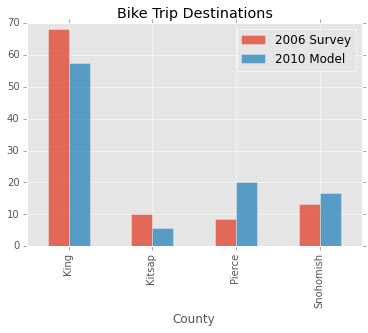

In [311]:
df[[srv_name,mdl_name]].plot(kind='bar', alpha=0.8, title='Bike Trip Destinations')

# Bike Trips Destinations (Districts)

In [312]:
df = pd.DataFrame({srv_name: (srv.groupby('New DistrictName').sum()['trexpfac']/srv.groupby('New DistrictName').sum()['trexpfac'].sum())*100,
              mdl_name: (mdl.groupby('New DistrictName').count()['TAZ']/mdl.groupby('New DistrictName').count()['TAZ'].sum())*100})
df

,2006 Survey,2010 Model
East Side,16.0%,17.5%
Everett-Lynwood-Edmonds,5.6%,9.3%
Kitsap,10.0%,5.6%
North Seattle-Shoreline,25.7%,9.9%
Renton-FedWay-Kent,8.6%,15.0%
S.Kitsap,nan%,0.6%
Seattle CBD,11.8%,9.6%
South Pierce,4.9%,10.3%
Suburban Snohomish,7.8%,7.5%
Tacoma,3.6%,9.4%


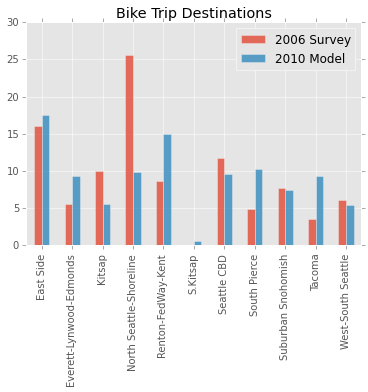

In [313]:
df[[srv_name,mdl_name]].plot(kind='bar', alpha=0.8, title='Bike Trip Destinations')

# Screenlines

In [488]:
screenline_df = pd.read_csv('D:/soundcast/soundcast/outputs/bike_screenlines.csv')

In [489]:
screenline_dict = {
                                4: 'Tacoma - East of CBD',
                                14: 'Auburn',
                                15: 'Auburn',
                                22: 'Tukwila',
                                23: 'Renton',
                                29: 'Seattle - South of CBD',
                                30: 'Bellevue/Redmond',
                                32: 'TransLake',
                                35: 'Ship Canal',
                                37: 'Kirkland/Redmond',
                                41: 'Seattle - North',
                                43: 'Lynnwood/Bothell',
                                44: 'Bothell',
                                46: 'Mill Creek',2: 'Parkland',
                                    3: 'Puyallup',
                                    7: 'Tacoma Narrows',
                                    18: 'Maple Valley',
                                    19: 'SeaTac',
                                    20: 'Kent',
                                    54: 'Gig Harbor',
                                    57: 'Kitsap - North',
                                    58: 'Agate Pass',
                                    60: 'Cross-Sound',
                                    66: 'Preston, Issaquah',
                                    71: 'Woodinville'}

In [492]:
screenline_df['Screenline Name'] = screenline_df['Screenline'].map(screenline_dict)
screenline_df.dropna(inplace=True)

In [497]:
# Add counter data
# Fremont bridge = 352
screenline_df[screenline_df['Screenline Name'] == 'Ship Canal']

,Unnamed: 0,Screenline,Volumes,Screenline Name
8,8,35,351.557068,Ship Canal


In [315]:
pd.reset_option('float_format')

# Destinations by Zone

In [382]:
# Sum all trips by destination zone and fill zones with zero trips
# survey trips first

#### uncomment to show trips by all modes, otherwise, showing bike trips only
# srv = survey_trip
# mdl = model_trip

df = pd.DataFrame(srv.groupby('dtaz').sum()['trexpfac'])
df['taz'] = df.index

# empty df to act as base for merging trip totals by destination zone
empty = pd.DataFrame(np.zeros(3700),columns=['taz'])
empty['taz']=[i+1 for i in empty.index]
df = empty.merge(df,on='taz', how='left')
df.fillna(0,inplace=True)
df[srv_name] = df['trexpfac']
df = df[['taz',srv_name]]

# Add model trips to this df
mdl_df = pd.DataFrame(mdl.groupby('dtaz').count()['mode'])
mdl_df[mdl_name] = mdl_df['mode']
mdl_df['taz'] = mdl_df.index

df = df.merge(mdl_df,on='taz',how='left')[[srv_name,mdl_name,'taz']]
df.index= df['taz']
df = df[[srv_name,mdl_name]]

In [383]:
df.max()[srv_name]

2592.5500000000002

**Trip End Totals by Zone**

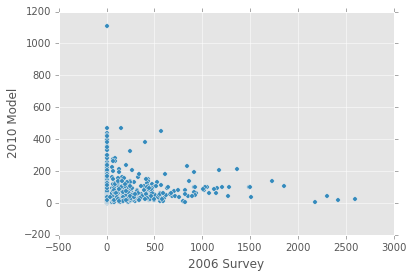

In [402]:
df.plot(kind='scatter', x=srv_name, y=mdl_name)
# df[df[srv_name]>0].plot(kind='hexbin', x=srv_name, y=mdl_name, gridsize=20)

** Distribution of Trip End Totals by Zone **

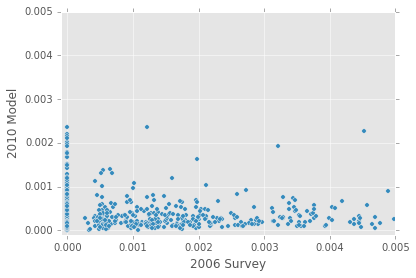

In [305]:
pd.DataFrame({mdl_name:df[mdl_name]/df[mdl_name].sum(),
             srv_name:df[srv_name]/df[srv_name].sum()}).plot(kind='scatter', x=srv_name, y=mdl_name,
                                                            xlim=[-.0001,0.005],ylim=[-0.0001,0.005])


## Heatmap

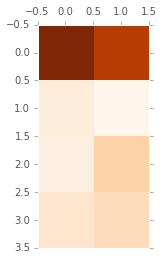

In [434]:
df = pd.DataFrame({srv_name: (srv.groupby('County').sum()['trexpfac']/srv.groupby('County').sum()['trexpfac'].sum())*100,
              mdl_name: (mdl.groupby('County').count()['TAZ']/mdl.groupby('County').count()['TAZ'].sum())*100})
df

ax = plt.imshow(df, interpolation='nearest', cmap='Oranges').axes
ax.grid('off')
ax.xaxis.tick_top()

In [105]:
len(df)

404

In [88]:
df.fillna(0,inplace=True)

## Skim Results

In [ ]:
# Load skim data
h5data = h5py.File(r'D:\soundcast\soundcast\inputs\7to8.h5')
perceived = pd.DataFrame(h5data['Skims']['mfbkpt'][:])
actual = pd.DataFrame(h5data['Skims']['mfbkat'][:])

In [ ]:
# Get the TAZ lookup dict
tazlookup = pd.read_csv(r'D:\soundcast\soundcast\scripts\summarize\inputs\calibration\TAZ_TAD_County.csv')

In [ ]:
tazlookup;

In [ ]:
# Extract link values and compare to counts